In [227]:
import pandas as pd

In [228]:
import pandas as pd
from sqlalchemy import create_engine, text

# Connect to the database
engine = create_engine('mysql+pymysql://root:@localhost/space_launch_db')

# Query to get all table names in the current database
query_tables = """
SELECT TABLE_NAME 
FROM information_schema.TABLES 
WHERE TABLE_SCHEMA = DATABASE()
"""

# Open a connection and execute the query to get table names
with engine.connect() as connection:
    result_tables = connection.execute(text(query_tables)).fetchall()

# Extract table names from the result
table_names = [row[0] for row in result_tables]

# Dictionary to hold the DataFrames for each table
dfs = {}

# Loop through each table, load it into a DataFrame, and store it in the dictionary
for table in table_names:
    query = f"SELECT * FROM {table}"
    dfs[table] = pd.read_sql(query, engine)

# Now all tables are loaded into DataFrames and stored in the `dfs` dictionary
# Example: To access a specific table's DataFrame, you can use dfs['table_name']
# Print all table names and their corresponding DataFrame shapes
for table, df in dfs.items():
    print(f"Table: {table}, Shape: {df.shape}")


Table: dim_countries, Shape: (249, 2)
Table: dim_locations, Shape: (137, 5)
Table: dim_organisations, Shape: (56, 3)
Table: fact_conflicts, Shape: (2686, 6)
Table: fact_launches, Shape: (4324, 11)


In [229]:
fact_launches = dfs['fact_launches']
fact_conflicts = dfs['fact_conflicts']
dim_countries = dfs['dim_countries']
dim_locations = dfs['dim_locations']
dim_organisations = dfs['dim_organisations']
fact_launches = fact_launches.merge(dim_locations, on='location_id', how='left')
fact_launches = fact_launches.merge(dim_organisations, on='organisation_id', how='left')
fact_launches = fact_launches.merge(dim_countries, on='country_id', how='left')
fact_launches.drop(columns= ['organisation_id', 'location_id'], inplace = True)

In [234]:
#fact_launches = fact_launches.merge(fact_conflicts, on='country_id', how='left')

In [235]:
fact_launches.drop(columns= ['country_id'], inplace = True)

In [236]:
fact_launches.columns

Index(['id', 'date', 'detail', 'rocket_status', 'price', 'mission_status',
       'wind_speed', 'humidity', 'temperature', 'location', 'latitude',
       'longitude', 'organisation', 'isprivate', 'country'],
      dtype='object')

In [237]:
import pandas as pd

# Check for missing values
missing_values = fact_launches.isnull().sum()

# Basic statistics for numerical columns
stats = fact_launches.describe()

# Unique values in categorical columns
unique_values = {col: fact_launches[col].unique() for col in fact_launches.select_dtypes(include=['object']).columns}

print(missing_values)
print(stats)
print(unique_values)


id                   0
date               126
detail               0
rocket_status        0
price             3360
mission_status       0
wind_speed           0
humidity             0
temperature          0
location             0
latitude             0
longitude            0
organisation         0
isprivate            0
country              0
dtype: int64
                id        price   wind_speed     humidity  temperature  \
count  4324.000000   964.000000  4324.000000  4324.000000  4324.000000   
mean   2161.500000   153.792199     8.981979    64.654213     7.976597   
std    1248.375611   288.450732     3.270525    11.712711    11.040682   
min       0.000000     5.300000     2.002310    30.707400   -14.962000   
25%    1080.750000    40.000000     6.439013    56.310325    -0.330433   
50%    2161.500000    62.000000     8.897065    64.737100     7.542095   
75%    3242.250000   164.000000    11.636850    73.439400    15.515375   
max    4323.000000  5000.000000    14.997300    89

In [238]:
fact_launches.columns

Index(['id', 'date', 'detail', 'rocket_status', 'price', 'mission_status',
       'wind_speed', 'humidity', 'temperature', 'location', 'latitude',
       'longitude', 'organisation', 'isprivate', 'country'],
      dtype='object')

/var/folders/d2/zqv2mpg17tzb0413h3b_jwb00000gn/T/ipykernel_10146/1293735923.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_launches = fact_launches.resample('M', on='date').size()
/var/folders/d2/zqv2mpg17tzb0413h3b_jwb00000gn/T/ipykernel_10146/1293735923.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_launches = fact_launches.resample('Y', on='date').size()


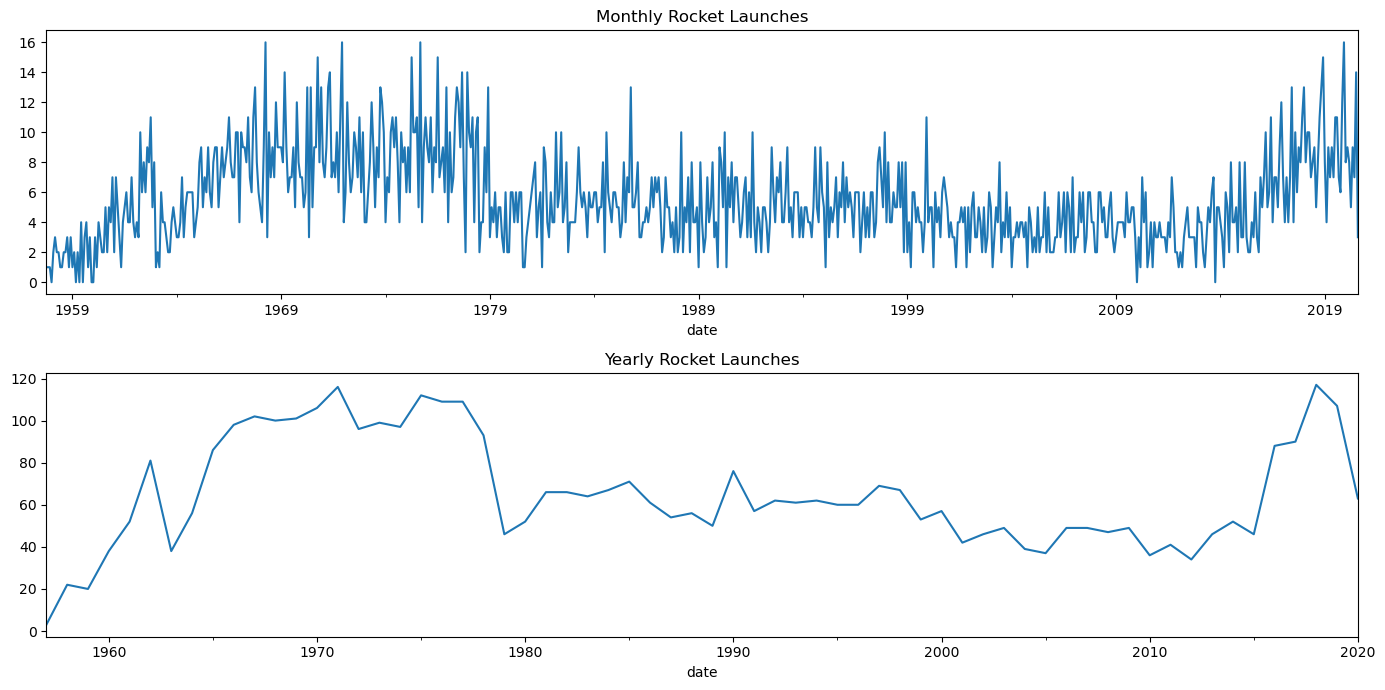

In [239]:
fact_launches['date'] = pd.to_datetime(fact_launches['date'])
monthly_launches = fact_launches.resample('M', on='date').size()
yearly_launches = fact_launches.resample('Y', on='date').size()

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
monthly_launches.plot()
plt.title('Monthly Rocket Launches')

plt.subplot(2, 1, 2)
yearly_launches.plot()
plt.title('Yearly Rocket Launches')

plt.tight_layout()
plt.show()


In [240]:
rocket_status_counts = fact_launches['rocket_status'].value_counts()
mission_status_counts = fact_launches['mission_status'].value_counts()

print(rocket_status_counts)
print(mission_status_counts)


rocket_status
StatusRetired    3534
StatusActive      790
Name: count, dtype: int64
mission_status
Success              3879
Failure               339
Partial Failure       102
Prelaunch Failure       4
Name: count, dtype: int64


In [241]:
# Convert mission_status to binary for success/failure
fact_launches['mission_success'] = fact_launches['mission_status'].apply(lambda x: 1 if x == 'Success' else 0)

# Correlation matrix
correlation_matrix = fact_launches[['wind_speed', 'humidity', 'temperature', 'mission_success']].corr()

print(correlation_matrix)


                 wind_speed  humidity  temperature  mission_success
wind_speed         1.000000  0.183737    -0.264901         0.041596
humidity           0.183737  1.000000    -0.632737         0.000749
temperature       -0.264901 -0.632737     1.000000         0.010676
mission_success    0.041596  0.000749     0.010676         1.000000


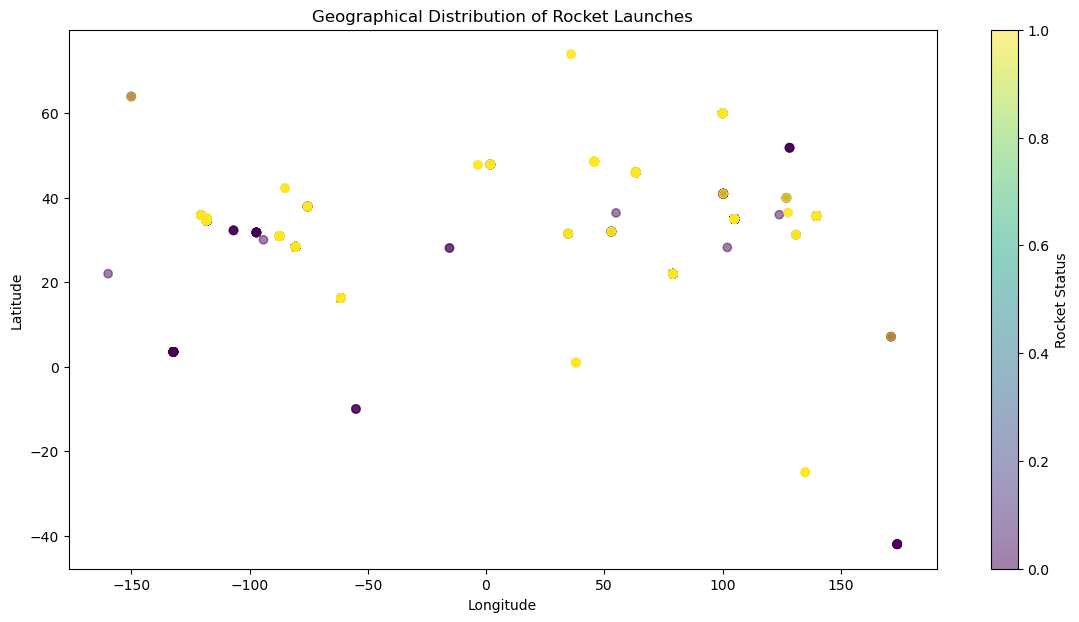

In [242]:
# Launches by country
launches_by_country = fact_launches['country'].value_counts()

# Plot geographical distribution
plt.figure(figsize=(14, 7))
plt.scatter(fact_launches['longitude'], fact_launches['latitude'], alpha=0.5, c=fact_launches['rocket_status'].astype('category').cat.codes)
plt.colorbar(label='Rocket Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Distribution of Rocket Launches')
plt.show()


In [243]:
# Group the data by 'country' and count the total number of launches per country
launches_by_country = fact_launches.groupby('country')['id'].count().reset_index()
launches_by_country.columns = ['country', 'total_launches']


In [244]:
successful_launches_by_country = fact_launches[fact_launches['mission_status'] == 'Success'].groupby('country')['id'].count().reset_index()
successful_launches_by_country.columns = ['country', 'successful_launches']


In [245]:
# Merge the total launches and successful launches into one DataFrame
country_analysis = pd.merge(launches_by_country, successful_launches_by_country, on='country', how='left')

# Fill NaN values in 'successful_launches' with 0 for countries with no successful launches
country_analysis['successful_launches'].fillna(0, inplace=True)

# Calculate the success rate per country
country_analysis['success_rate'] = country_analysis['successful_launches'] / country_analysis['total_launches'] * 100

# Sort by the number of total launches or success rate
country_analysis = country_analysis.sort_values(by='total_launches', ascending=False)


/var/folders/d2/zqv2mpg17tzb0413h3b_jwb00000gn/T/ipykernel_10146/2766960972.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  country_analysis['successful_launches'].fillna(0, inplace=True)


In [246]:
print(country_analysis)

          country  total_launches  successful_launches  success_rate
12         Russia            1398               1305.0     93.347639
15  United States            1385               1219.0     88.014440
8      Kazakhstan             701                608.0     86.733238
3          France             303                285.0     94.059406
2           China             269                244.0     90.706320
7           Japan             126                113.0     89.682540
4           India              76                 63.0     82.894737
5            Iran              14                  5.0     35.714286
10    New Zealand              13                 11.0     84.615385
6          Israel              11                  9.0     81.818182
9           Kenya               9                  9.0    100.000000
0       Australia               6                  3.0     50.000000
11    North Korea               5                  2.0     40.000000
1          Brazil               3 

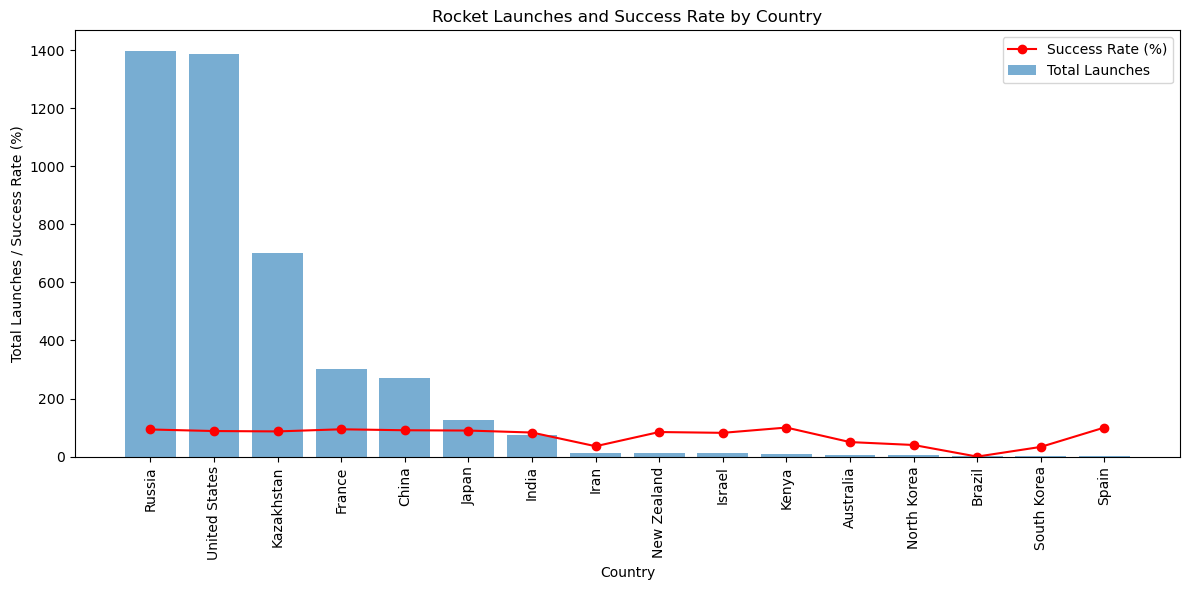

In [247]:
import matplotlib.pyplot as plt

# Plot total launches by country
plt.figure(figsize=(12, 6))
plt.bar(country_analysis['country'], country_analysis['total_launches'], label='Total Launches', alpha=0.6)

# Add a line plot for success rate
plt.plot(country_analysis['country'], country_analysis['success_rate'], color='red', marker='o', label='Success Rate (%)')

plt.xlabel('Country')
plt.ylabel('Total Launches / Success Rate (%)')
plt.title('Rocket Launches and Success Rate by Country')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


In [248]:
fact_launches.columns

Index(['id', 'date', 'detail', 'rocket_status', 'price', 'mission_status',
       'wind_speed', 'humidity', 'temperature', 'location', 'latitude',
       'longitude', 'organisation', 'isprivate', 'country', 'mission_success'],
      dtype='object')

In [249]:
fact_launches['isprivate'].value_counts()

isprivate
0    3341
1     983
Name: count, dtype: int64

In [250]:
# Group the data by 'isprivate' and count the total number of launches
private_vs_non_private = fact_launches.groupby('isprivate')['id'].count().reset_index()
private_vs_non_private.columns = ['isprivate', 'total_launches']

# Count the number of successful launches for private and non-private missions
successful_private_vs_non_private = fact_launches[fact_launches['mission_status'] == 'Success'].groupby('isprivate')['id'].count().reset_index()
successful_private_vs_non_private.columns = ['isprivate', 'successful_launches']

# Merge the total launches and successful launches
private_mission_analysis = pd.merge(private_vs_non_private, successful_private_vs_non_private, on='isprivate', how='left')

# Fill NaN values in 'successful_launches' with 0 for cases where there are no successful launches
private_mission_analysis['successful_launches'].fillna(0, inplace=True)

# Calculate the success rate for private vs non-private missions
private_mission_analysis['success_rate'] = (private_mission_analysis['successful_launches'] / private_mission_analysis['total_launches']) * 100

# Map the boolean values to more understandable labels
private_mission_analysis['isprivate'] = private_mission_analysis['isprivate'].map({1: 'Private', 0: 'Non-Private'})

# Display the final analysis
print(private_mission_analysis)


     isprivate  total_launches  successful_launches  success_rate
0  Non-Private            3341                 2994     89.613888
1      Private             983                  885     90.030519


/var/folders/d2/zqv2mpg17tzb0413h3b_jwb00000gn/T/ipykernel_10146/2501182414.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  private_mission_analysis['successful_launches'].fillna(0, inplace=True)


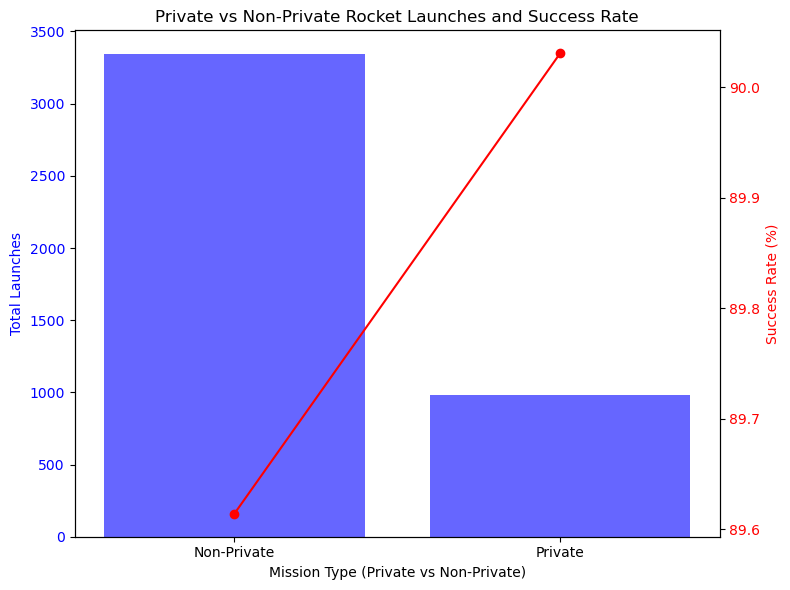

In [251]:
import matplotlib.pyplot as plt

# Create a figure and axis with twin axes
fig, ax1 = plt.subplots(figsize=(8, 6))

# Bar plot for total launches on the first y-axis (left)
ax1.bar(private_mission_analysis['isprivate'], private_mission_analysis['total_launches'], color='blue', alpha=0.6, label='Total Launches')
ax1.set_xlabel('Mission Type (Private vs Non-Private)')
ax1.set_ylabel('Total Launches', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis (right) for the success rate
ax2 = ax1.twinx()
ax2.plot(private_mission_analysis['isprivate'], private_mission_analysis['success_rate'], color='red', marker='o', label='Success Rate (%)')
ax2.set_ylabel('Success Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and layout
plt.title('Private vs Non-Private Rocket Launches and Success Rate')
fig.tight_layout()

plt.show()


In [252]:
# Check the unique values in the 'mission_success' column
print(fact_launches['mission_success'].unique())


[1 0]


In [253]:
# Calculate success rate and number of launches per country
launches_and_success_rate = fact_launches.groupby('country').agg(
    number_of_launches=('mission_success', 'count'),
    success_rate=('mission_success', 'mean')  # Mean gives the success rate
).reset_index()

# Convert success rate to percentage
launches_and_success_rate['success_rate'] *= 100

# Sort by number of launches for better visualization
launches_and_success_rate = launches_and_success_rate.sort_values(by='number_of_launches', ascending=False)


/var/folders/d2/zqv2mpg17tzb0413h3b_jwb00000gn/T/ipykernel_10146/1134674564.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(launches_and_success_rate['country'], rotation=90)  # Rotate x-axis labels for better readability


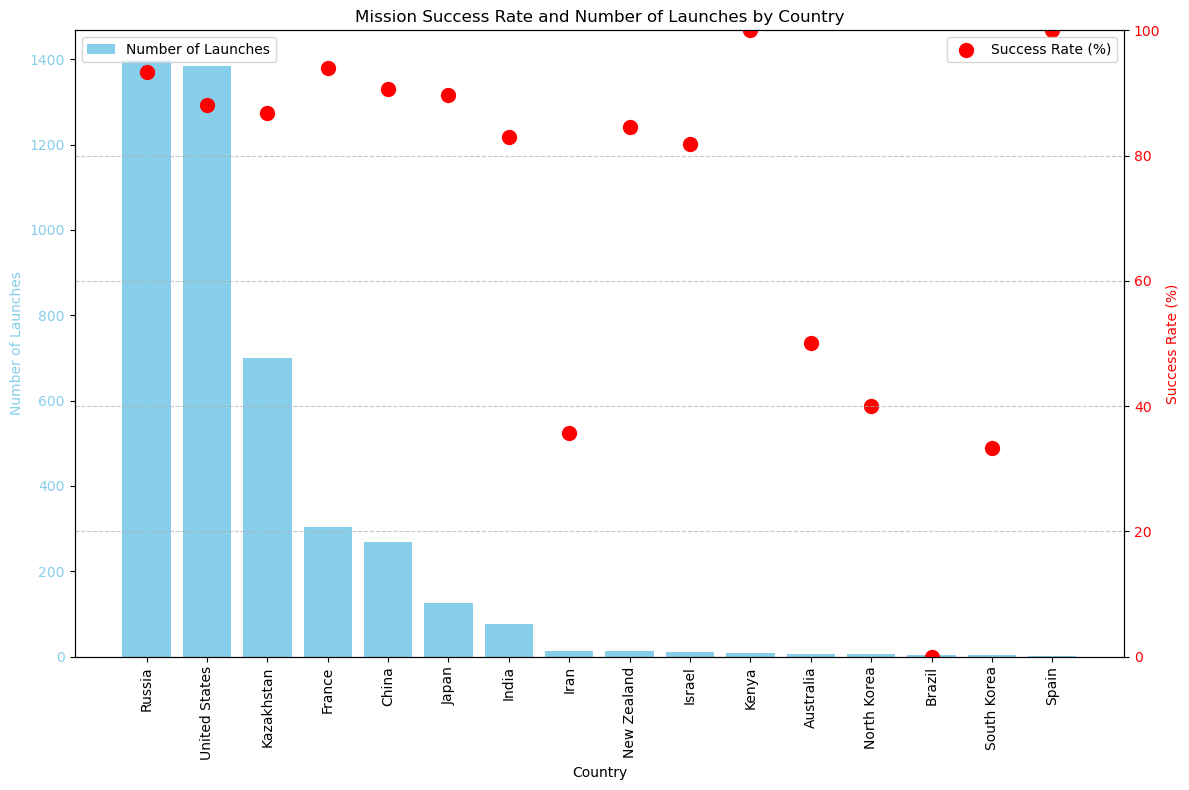

In [254]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar plot for number of launches
bars = ax1.bar(launches_and_success_rate['country'], launches_and_success_rate['number_of_launches'], color='skyblue', label='Number of Launches')
ax1.set_xlabel('Country')
ax1.set_ylabel('Number of Launches', color='skyblue')
ax1.set_title('Mission Success Rate and Number of Launches by Country')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(launches_and_success_rate['country'], rotation=90)  # Rotate x-axis labels for better readability

# Scatter plot for success rate
ax2 = ax1.twinx()  # Create a second y-axis to plot the success rate
scatter = ax2.scatter(launches_and_success_rate['country'], launches_and_success_rate['success_rate'], color='red', marker='o', s=100, label='Success Rate (%)')
ax2.set_ylabel('Success Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 100)  # Set y-axis limit for percentage

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add grid for the secondary y-axis
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [255]:
df = fact_launches

In [262]:
fact_conflicts = fact_conflicts.merge(dim_countries, on='country_id', how='left')

In [267]:
fact_conflicts.drop(columns=['country_id'], inplace=True)

In [275]:
fact_launches.columns

Index(['id', 'date', 'detail', 'rocket_status', 'price', 'mission_status',
       'wind_speed', 'humidity', 'temperature', 'location', 'latitude',
       'longitude', 'organisation', 'isprivate', 'country', 'mission_success'],
      dtype='object')

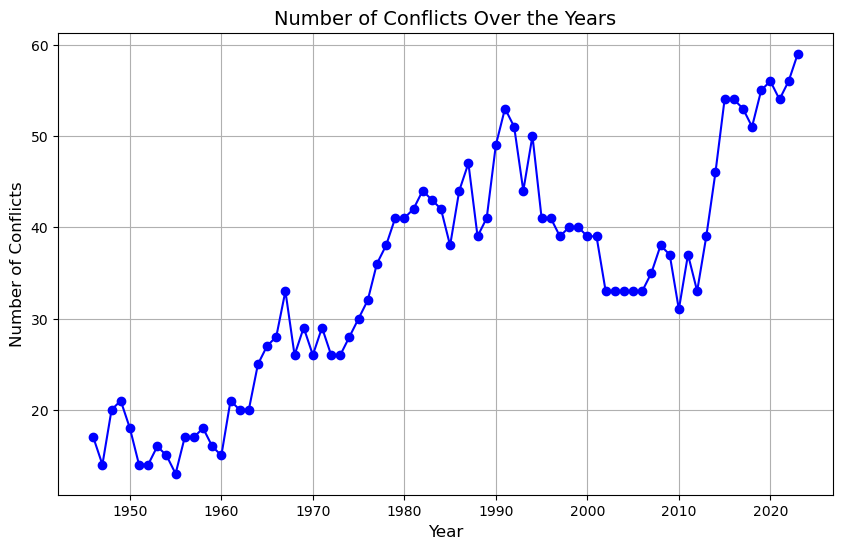

In [270]:
import seaborn as sns

# Conflicts by year
conflicts_by_year = fact_conflicts.groupby('year')['conflict_id'].count()

# Plotting
plt.figure(figsize=(10,6))
plt.plot(conflicts_by_year.index, conflicts_by_year.values, marker='o', linestyle='-', color='b')
plt.title('Number of Conflicts Over the Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Conflicts', fontsize=12)
plt.grid(True)
plt.show()


/var/folders/d2/zqv2mpg17tzb0413h3b_jwb00000gn/T/ipykernel_10146/443967325.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=intensity_level_counts.index, y=intensity_level_counts.values, palette='viridis')


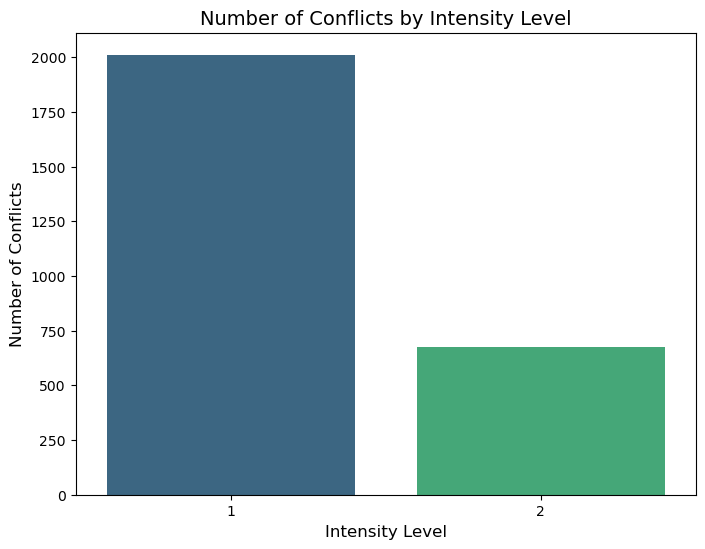

In [271]:
# Conflicts by intensity level
intensity_level_counts = fact_conflicts['intensity_level'].value_counts()

# Plotting
plt.figure(figsize=(8,6))
sns.barplot(x=intensity_level_counts.index, y=intensity_level_counts.values, palette='viridis')
plt.title('Number of Conflicts by Intensity Level', fontsize=14)
plt.xlabel('Intensity Level', fontsize=12)
plt.ylabel('Number of Conflicts', fontsize=12)
plt.show()


/var/folders/d2/zqv2mpg17tzb0413h3b_jwb00000gn/T/ipykernel_10146/1355904154.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conflicts_by_country.values, y=conflicts_by_country.index, palette='coolwarm')


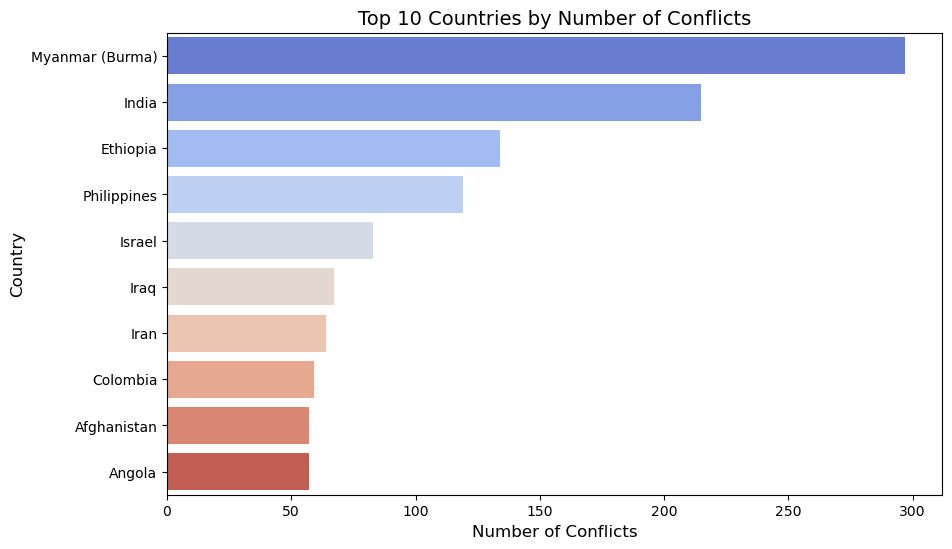

In [272]:
# Conflicts by country
conflicts_by_country = fact_conflicts.groupby('country')['conflict_id'].count().sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x=conflicts_by_country.values, y=conflicts_by_country.index, palette='coolwarm')
plt.title('Top 10 Countries by Number of Conflicts', fontsize=14)
plt.xlabel('Number of Conflicts', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.show()


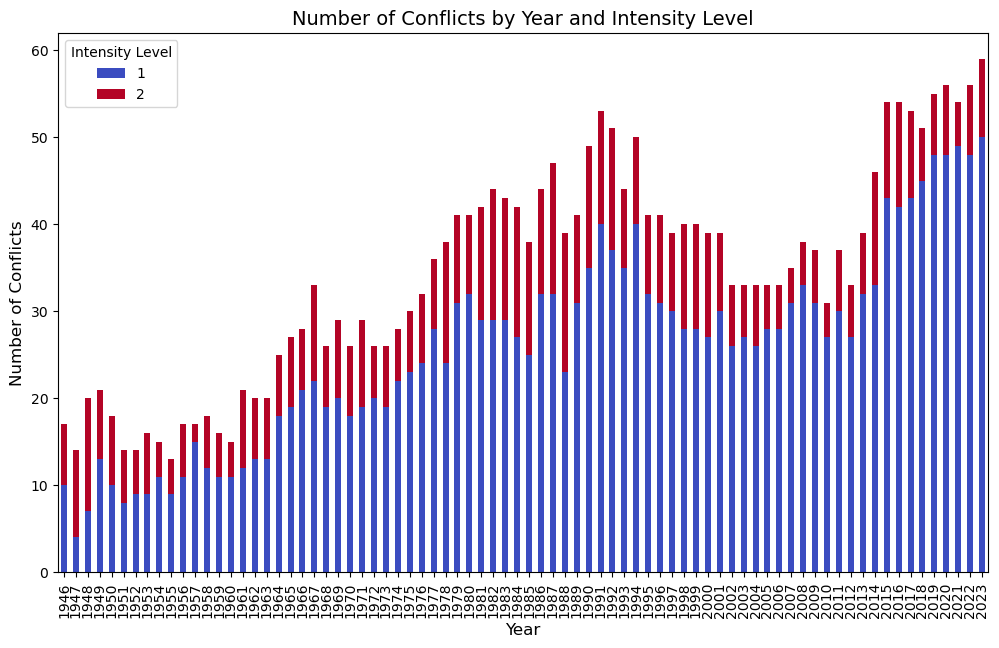

In [273]:
# Conflicts by year and intensity level
conflicts_by_year_intensity = fact_conflicts.groupby(['year', 'intensity_level'])['conflict_id'].count().unstack().fillna(0)

# Plotting
conflicts_by_year_intensity.plot(kind='bar', stacked=True, figsize=(12, 7), cmap='coolwarm')
plt.title('Number of Conflicts by Year and Intensity Level', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Conflicts', fontsize=12)
plt.legend(title='Intensity Level')
plt.show()


/var/folders/d2/zqv2mpg17tzb0413h3b_jwb00000gn/T/ipykernel_10146/1659637445.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=side_a_involvement.values, y=side_a_involvement.index, palette='Blues_d')
/var/folders/d2/zqv2mpg17tzb0413h3b_jwb00000gn/T/ipykernel_10146/1659637445.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=side_b_involvement.values, y=side_b_involvement.index, palette='Reds_d')


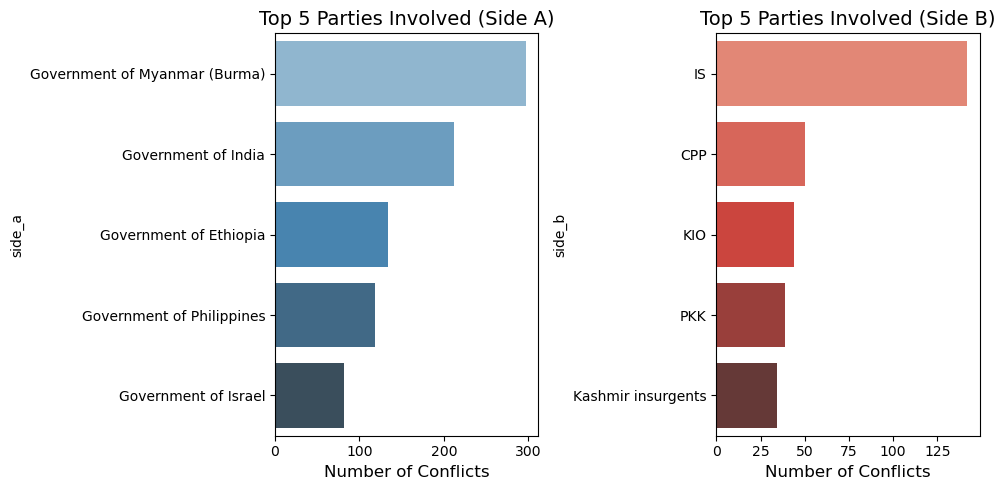

In [274]:
# Most frequent Side A and Side B parties
side_a_involvement = fact_conflicts['side_a'].value_counts().head(5)
side_b_involvement = fact_conflicts['side_b'].value_counts().head(5)

# Plotting Side A
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
sns.barplot(x=side_a_involvement.values, y=side_a_involvement.index, palette='Blues_d')
plt.title('Top 5 Parties Involved (Side A)', fontsize=14)
plt.xlabel('Number of Conflicts', fontsize=12)

# Plotting Side B
plt.subplot(1, 2, 2)
sns.barplot(x=side_b_involvement.values, y=side_b_involvement.index, palette='Reds_d')
plt.title('Top 5 Parties Involved (Side B)', fontsize=14)
plt.xlabel('Number of Conflicts', fontsize=12)

plt.tight_layout()
plt.show()


In [280]:

# Aggregate conflicts by year and country
conflict_counts = fact_conflicts.groupby(['country', 'year']).size().reset_index(name='conflict_count')

# Aggregate launches by year and country
launch_counts = fact_launches.groupby(['country', 'year']).size().reset_index(name='launch_count')

# Merge the two aggregations
merged_agg_df = pd.merge(conflict_counts, launch_counts, on=['country', 'year'], how='outer').fillna(0)


conflict_status
Conflict        0.383333
No Conflict    11.540000
Name: launch_count, dtype: float64


/var/folders/d2/zqv2mpg17tzb0413h3b_jwb00000gn/T/ipykernel_10146/744525540.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_launches.index, y=average_launches.values, palette='viridis')


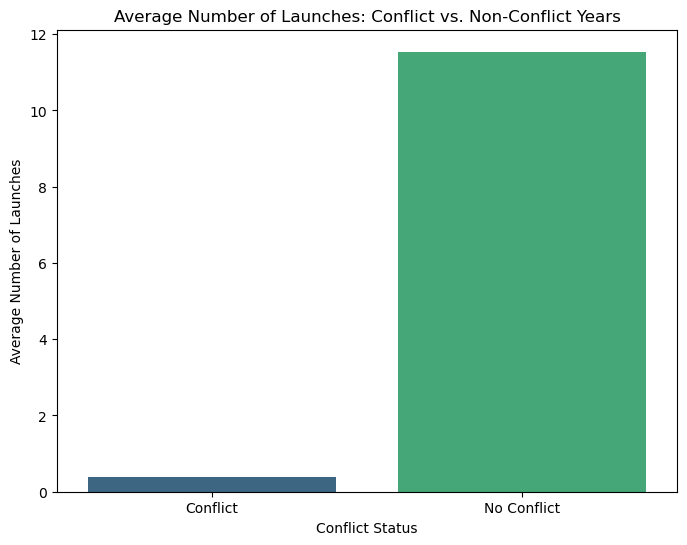

In [281]:
import matplotlib.pyplot as plt

# Determine if a year had any conflicts
merged_agg_df['conflict_status'] = merged_agg_df['conflict_count'].apply(lambda x: 'Conflict' if x > 0 else 'No Conflict')

# Calculate average launches during conflict and non-conflict years
average_launches = merged_agg_df.groupby('conflict_status')['launch_count'].mean()
print(average_launches)

# Plotting
plt.figure(figsize=(8,6))
sns.barplot(x=average_launches.index, y=average_launches.values, palette='viridis')
plt.title('Average Number of Launches: Conflict vs. Non-Conflict Years')
plt.xlabel('Conflict Status')
plt.ylabel('Average Number of Launches')
plt.show()


In [283]:
# Aggregate the number of launches and conflicts by year
launches_by_year = merged_agg_df.groupby('year')['launch_count'].sum().reset_index()
conflicts_by_year = merged_agg_df.groupby('year')['conflict_count'].sum().reset_index()

# Merge these two aggregates to ensure they have the same years
trend_df = pd.merge(launches_by_year, conflicts_by_year, on='year', how='outer').fillna(0)


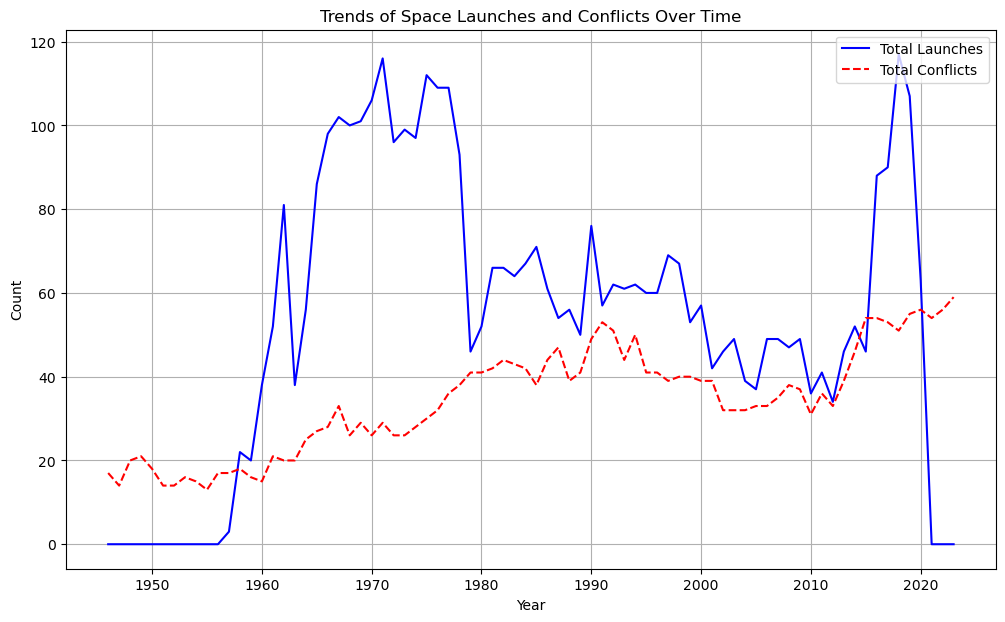

In [284]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Plot number of launches over time
plt.plot(trend_df['year'], trend_df['launch_count'], label='Total Launches', color='b')

# Plot number of conflicts over time
plt.plot(trend_df['year'], trend_df['conflict_count'], linestyle='--', label='Total Conflicts', color='r')

plt.title('Trends of Space Launches and Conflicts Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
